# Markov Transition Kalman Filter (Forced Linear Advection Diffusion)

## Reference

- 樋口知之編著，上野玄太・中野慎也・中村和幸・吉田亮著，データ同化入門ー次世代のシミュレーション技術ー，朝倉書店，2011．
- 淡路敏之・蒲地政文・池田元美・石川洋一，データ同化ー観測・実験とモデルを融合するイノベーションー，京都大学学術出版会，2009．

## -----------コードを書く前の下準備----------

### Linear Gauss State Space Model（線形・ガウス状態空間モデル）

一般に，カルマンフィルタでは，線形・ガウス状態空間モデルを考える．これは，次の様に表せる．
$$
\begin{align}
&x_{t+1} = F_tx_t + b + N(0,Q_t)\\
&y_t = H_tx_t + d + N(0,R_t)
\end{align}
$$
ここで，$x_t$は時刻$t$における状態変数，$y_t$は時刻$t$における観測変数，$F_t$はシステム行列，$Q_t$はシステムノイズの共分散行列，$H_t$は観測行列，$R_t$は観測ノイズの共分散行列，$b,d$は各モデルのオフセット（切片）を表す．

### Kalman Filter Algorithm

カルマンフィルターのアルゴリズムは，以下であった．
1. 初期状態のフィルタ分布の平均 $x_{0|0}$，共分散行列$V_{0|0}$を与える
1. $t=1$から$T$まで次の予測ステップ・フィルタステップを繰り返す

予測ステップ
$$
\begin{gather}
x_{t|t-1}=F_tx_{t-1|t-1}\\
V_{t|t-1}=F_tV_{t-1|t-1}F_t^T+G_tQ_tG_t
\end{gather}
$$

フィルタステップ
$$
\begin{gather}
K_t = V_{t|t-1}H_t^T (H_tV_{t|t-1}H_t^T+R_t)^{-1}\\
x_{t|t} = x_{t|t-1}+K_t(y_t-H_tx_{t|t-1})\\
V_{t|t} = V_{t|t-1} - K_t H_t V_{t|t-1}
\end{gather}
$$

### RTS Smoothing Algorithm

カルマンフィルタによって，$x_{T|T},V_{T|T}$が得られたら，$t=T-1,\cdots,0$に対して，
$$
\begin{gather*}
A_t=V_{t|t}F_{t+1}^TV_{t+1|t}^{-1}\\
x_{t|T} = x_{t|t} + A_t(x_{t+1|T} - x_{t+1|t})\\
V_{t|T} = V_{t|t} + A_t(V_{t+1|T} - V_{t+1|t})A_t^T
\end{gather*}
$$
によって固定区間平滑化分布の平均$x_{t|T}$と共分散行列$V_{t|T}$がわかる．ここで，$A_t$は固定区間平滑化ゲインと呼ばれている．

## ----------コード作成----------

ディレクトリ構造について
- Data_Assimilation > phase2 > source : saving place for source
- Data_Assimilation > phase2 > plot : saving place for plot result

バージョンについて
- Mac OS 10.13
- Jupyter 4.3.0
- Python 3.6.1
- numpy 1.14.1
- pandas 0.20.1
- matplotlib 2.0.2
- seaborn 0.7.1
- scikit_learn 0.18.1
- scipy 0.19.0

In [1]:
# install packages
import math
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from scipy import interpolate
from IPython.core.display import display

import sys
sys.path.append("../")
from pyassim import *

### カルマンフィルター実装テスト

In [2]:
# Euler forward differential
def Euler_forward_differential (state, m, w, k, r, dt, t) :
    '''
    <Input Variables>
    state [n_dim] {float} : position and velocity (x, v) (位置と速度)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    t {int} : time (ステップ番号)
    
    <Variables>
    x {float} : position (位置)
    v {float} : velocity (速度)
    '''
    x = state[0]
    v = state[1]

    state[0] = x + dt * v
    state[1] = v + dt / m * (- k * x - r * v + w(t * dt))
    return state

# perfect simulation
def perfect_simulation (initial_state, m, w, k, r, dt, T) :
    '''
    <Input Variables>
    initial_state [n_dim] {float} : initial state (x0, v0) (初期状態変数)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    T {float} : end time (最終時間)
    
    <Variables in this function>
    L {int} : length of time (ステップ数)
    x {float} : position (位置)
    v {float} : velocity (速度)
    w_perf {float} : perfect forcing (外力)
    state [n_dim] {float} : position and velocity (updated) (状態)
    '''
    L = math.ceil(T / dt) + 1
    x = np.zeros(L + 1)
    v = np.zeros(L + 1)
    w_perf = np.zeros(L + 1)
    state = initial_state
    x[0] = state[0]
    v[0] = state[1]
    w_perf[0] = w(0)
    for t in range(L) :
        state = Euler_forward_differential(state, m, w, k, r, dt, t)
        x[t + 1] = state[0]
        v[t + 1] = state[1]
        w_perf[t + 1] = w((t + 1) * dt)
    return x, v, w_perf

# observation (perfect simulation + noise)
def make_observation (initial_state, m, w, k, r, dt, T, noise_sd) :
    '''
    <Input Variables>
    initial_state [n_dim] {float} : initial state (x0, v0) (初期状態変数)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    T {float} : end time (最終時間)
    noise_sd {float} : standard deviation of Nomal noise (観測ノイズの標準偏差)
    
    <Variables in this function>
    L {int} : length of time (ステップ数)
    x {float} : position (位置)
    v {float} : velocity (速度)
    w_obs {float} : forcing (観測外力)
    state [n_dim] {float} : position and velocity (updated) (状態)
    noise [n_dim] {float} : normal noise ~ N(0, noise_sd**2) (観測ノイズ)
    '''
    L = math.ceil(T / dt) + 1
    x = np.zeros(L + 1)
    v = np.zeros(L + 1)
    w_obs = np.zeros(L + 1)
    state = initial_state
    x[0] = state[0]
    v[0] = state[1]
    w_obs[0] = w(0)
    for t in range(L) :
        if t%2 == 0 :
            noise = rd.normal(0, noise_sd, size = 1)
        else :
            noise = 0
        w_obs[t + 1] = w((t + 1) * dt) + noise
        state = Euler_forward_differential(state, m, w, k, r, dt, t) \
            + np.array([dt / m * noise, 0])
        x[t + 1] = state[0]
        v[t + 1] = state[1]
    return x, v, w_obs

# simulation (perfect simulation + noise)
def make_simulation (initial_state, m, w, k, r, dt, T, noise_sd) :
    '''
    <Input Variables>
    initial_state [n_dim] {float} : initial state (x0, v0) (初期状態変数)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    T {float} : end time (最終時間)
    noise_sd {float} : standard deviation of Nomal noise (観測ノイズの標準偏差)
    
    <Variables in this function>
    L {int} : length of time (ステップ数)
    x {float} : position (位置)
    v {float} : velocity (速度)
    w_obs {float} : forcing (観測外力)
    state [n_dim] {float} : position and velocity (updated) (状態)
    noise [n_dim] {float} : normal noise ~ N(0, noise_sd**2) (観測ノイズ)
    '''
    L = math.ceil(T / dt) + 1
    x = np.zeros(L + 1)
    v = np.zeros(L + 1)
    w_obs = np.zeros(L + 1)
    state = initial_state
    x[0] = state[0]
    v[0] = state[1]
    w_obs[0] = w(0)
    for t in range(L) :
        if t%2 == 0 :
            noise = rd.normal(0, noise_sd, size = 1)
        w_obs[t + 1] = w((t + 1) * dt) + noise
        state = Euler_forward_differential(state, m, w, k, r, dt, t) \
            + np.array([dt / m * noise, 0])
        x[t + 1] = state[0]
        v[t + 1] = state[1]
    return x, v, w_obs

In [3]:
# forcing function
def w (t) :
    '''
    <Input Variable>
    t {float} : time
    '''
    return np.sin(np.pi * t / 5)

In [4]:
# decide parameters
#n_dim_sys = 2
#n_dim_obs = 1
perf_initial = np.array([5.0, 0.0])
sim_initial = np.array([[6.0, 0.0]])
obs_initial = perf_initial
m = 1.0
k = 0.5
r = 0.75
dt = 1
noise_sd = 3.0 #1.0
sim_noise = 0.5**2
T = 100

In [5]:
wd = np.zeros(T + 2)
for t in range(T + 2) :
    wd[t] = w(t)

In [6]:
# setup matrix
F = np.array([[1, dt], [- k * dt / m, 1 - r * dt / m]])
G = np.array([[0], [dt / m]])
H = np.array([[1, 0]])
Gw = np.dot(np.array([G[:, 0]]).T, [wd]).T
V0 = np.array([[1, 0], [0, 0]])
Q = np.array([[sim_noise]])
R = np.array([[noise_sd**2]])

In [7]:
# confirmation
print('perf_initial:', perf_initial.shape)
print('sim_initial:', sim_initial.shape)
print('obs_initial:', obs_initial.shape)
print('F', F.shape)
print('G', G.shape)
print('H', H.shape)
print('Gw', Gw.shape)
print('V0', V0.shape)
print('Q', Q.shape)
print('R', R.shape)

perf_initial: (2,)
sim_initial: (1, 2)
obs_initial: (2,)
F (2, 2)
G (2, 1)
H (1, 2)
Gw (102, 2)
V0 (2, 2)
Q (1, 1)
R (1, 1)


In [8]:
x_perf, v_perf, w_perf = perfect_simulation(perf_initial, m, w, k, r, dt, T)
x_obs, v_obs, w_obs = make_observation(obs_initial, m, w, k, r, dt, T, noise_sd)

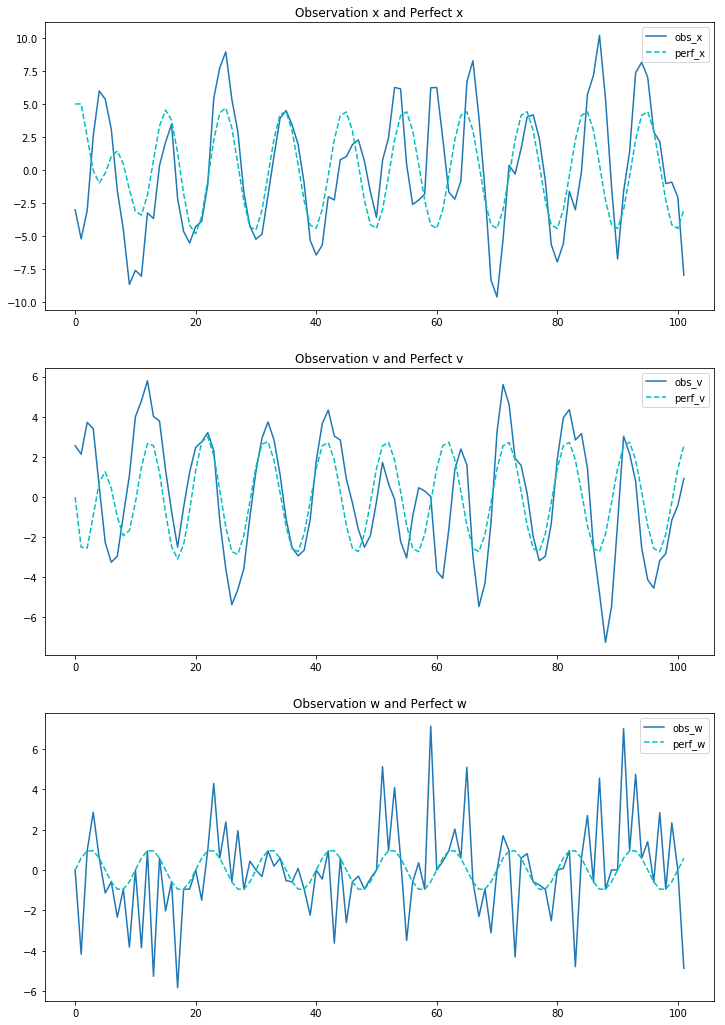

In [9]:
plt.figure(figsize = (12, 18))
plt.subplot(3, 1, 1)
plt.plot(x_obs, label = 'obs_x')
plt.plot(x_perf, linestyle = '--', color = 'c', label = 'perf_x')
plt.title("Observation x and Perfect x")
plt.legend(loc = 'best')

plt.subplot(3, 1, 2)
plt.plot(v_obs, label = 'obs_v')
plt.plot(v_perf, linestyle = '--', color = 'c', label = 'perf_v')
plt.title("Observation v and Perfect v")
plt.legend(loc = 'best')

plt.subplot(3, 1, 3)
plt.plot(w_obs, label = 'obs_w')
plt.plot(w_perf, linestyle = '--', color = 'c', label = 'perf_w')
plt.title("Observation w and Perfect w")
plt.legend(loc = 'best')
plt.show()

In [10]:
# make observation y
y  = np.array([x_obs]).T
print(y.shape)

(102, 1)


In [17]:
n_components = 10
mtkf = MarkovTransitionKalmanFilter(y, observation_matrices = H, transition_matrices = F,
                                    transition_offsets = Gw[:n_components], n_components=n_components,
                                    initial_covariance = V0, transition_covariance = G @ Q @ G.T,
                                    initial_mean = sim_initial, observation_covariance = R,
                                    initial_probability = np.arange(n_components),
                                    transition_kernel = 0.9 * np.eye(n_components) + 0.1 * np.random.rand(n_components, n_components)
                     )
mtkf.forward()

 filter calculating... t=101/102

In [18]:
mtkf.P

array([[6.95170708e-01, 3.46781333e-02, 4.80362049e-02, 6.46478441e-03,
        4.50738685e-02, 6.02632359e-02, 3.55665837e-02, 8.61124739e-03,
        2.12439284e-02, 5.57581309e-02],
       [7.11288639e-02, 6.94739608e-01, 3.60949096e-02, 6.60642001e-02,
        6.91776503e-02, 4.54769764e-03, 2.22696447e-02, 4.90019492e-02,
        4.63474251e-02, 1.09738599e-02],
       [4.86113368e-04, 1.67756396e-02, 6.49978612e-01, 2.78135914e-02,
        9.64161393e-03, 4.94099155e-03, 6.47858445e-02, 4.12344906e-02,
        6.53475305e-02, 4.40977130e-02],
       [3.02878089e-02, 3.49575469e-02, 1.38618761e-02, 6.51892026e-01,
        3.38635240e-02, 2.64682232e-02, 1.06168169e-02, 3.69522668e-03,
        3.06074837e-02, 9.25089946e-03],
       [2.91859886e-02, 3.49668163e-03, 5.64512444e-02, 1.71822040e-02,
        7.07041163e-01, 7.12770525e-02, 3.38094617e-03, 1.96160462e-03,
        1.16679133e-02, 7.22659928e-02],
       [2.16279088e-02, 4.93952744e-02, 6.27456927e-02, 6.16965257e-02,
   

In [19]:
mtkf.q

array([0.10721224, 0.11501701, 0.08174847, 0.05882209, 0.09345508,
       0.10723718, 0.10520402, 0.09708039, 0.11377168, 0.12045184])

In [14]:
kf = KalmanFilter(y, observation_matrices = H, transition_matrices = F,
                                    transition_offsets = Gw,
                                    initial_covariance = V0, transition_covariance = G @ Q @ G.T,
                                    initial_mean = sim_initial, observation_covariance = R
                     )
kf.forward()

 filter calculating... t=101/102

### 結果の表示

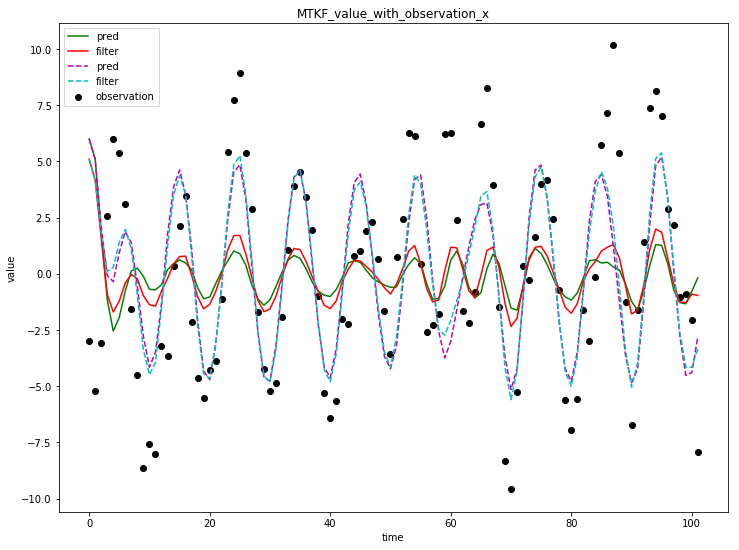

In [20]:
L = len(y)
plt.figure(figsize=(12, 9))

plt.scatter(range(L), x_obs, color = "k", marker = 'o', label = "observation")

plt.plot(mtkf.get_predicted_value(0), color = 'g', label =  'pred')
plt.plot(mtkf.get_filtered_value(0), color = 'r', label =  'filter')

plt.plot(kf.get_predicted_value(0), linestyle="--", color = 'm', label =  'pred')
plt.plot(kf.get_filtered_value(0), linestyle="--", color = 'c', label =  'filter')

plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("MTKF_value_with_observation_x")

plt.show()

- ノイズの分のズレが出ている

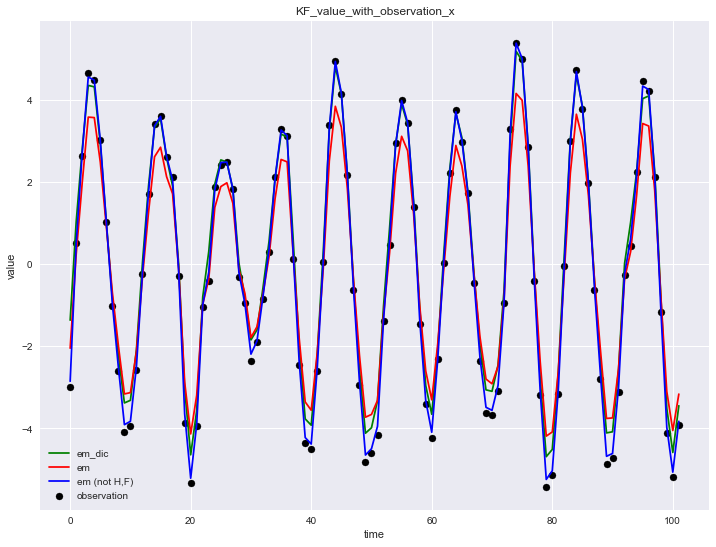

In [27]:
L = len(y)
plt.figure(figsize=(12, 9))

plt.scatter(range(L), x_obs, color = "k", marker = 'o', label = "observation")
plt.plot(kf_dic.get_filtered_value(0), color = 'g', label =  'em_dic')
plt.plot(kf_em.get_filtered_value(0), color = 'r', label =  'em')
plt.plot(kf.get_filtered_value(0), color = 'b', label =  'em (not H,F)')
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("KF_value_with_observation_x")

plt.show()

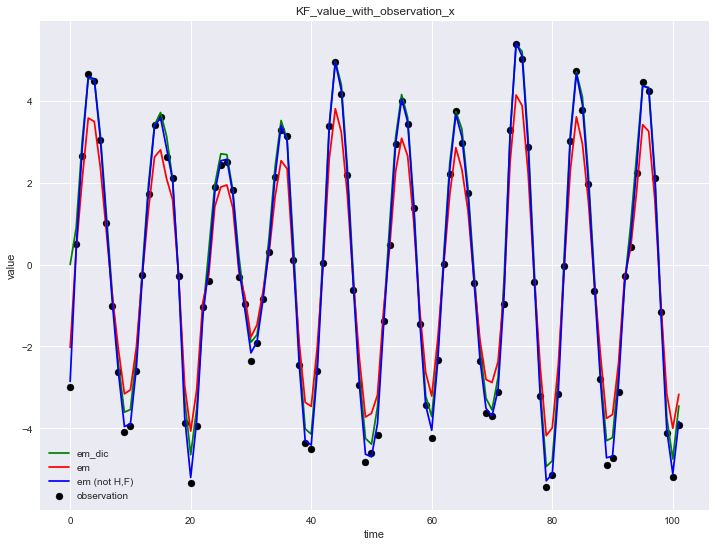

In [28]:
L = len(y)
plt.figure(figsize=(12, 9))

plt.scatter(range(L), x_obs, color = "k", marker = 'o', label = "observation")
plt.plot(kf_dic.get_RTS_smoothed_value(0), color = 'g', label =  'em_dic')
plt.plot(kf_em.get_RTS_smoothed_value(0), color = 'r', label =  'em')
plt.plot(kf.get_RTS_smoothed_value(0), color = 'b', label =  'em (not H,F)')
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("KF_value_with_observation_x")

plt.show()

うんちゃら

In [17]:
a

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [15]:
a = np.arange(9).reshape(3,3)
a.diagonal()

array([0, 4, 8])

In [21]:
np.diag(a.diagonal(1), 1)

array([[0, 1, 0],
       [0, 0, 5],
       [0, 0, 0]])

In [24]:
b = np.arange(3)
c = np.arange(4)+3
np.concatenate([b,c])

array([0, 1, 2, 3, 4, 5, 6])

In [21]:
a = np.arange(4)
a[[2]]

array([2])

In [23]:
a = np.arange(10)
a[3::3]

array([3, 6, 9])

In [13]:
dic = {'a' : [[0,1],[1,2]], 'b' : [1,5]}

if 'a' in dic.keys():
    print(dic.keys())

dict_keys(['a', 'b'])


In [14]:
a = 0.1 * np.arange(10)
b = [1,4]
a[b]

array([0.1, 0.4])

In [25]:
a = 0.1 * np.arange(10).reshape(5,2)
c = 10 * np.arange(10).reshape(5,2)
a, c

(array([[0. , 0.1],
        [0.2, 0.3],
        [0.4, 0.5],
        [0.6, 0.7],
        [0.8, 0.9]]), array([[ 0, 10],
        [20, 30],
        [40, 50],
        [60, 70],
        [80, 90]]))

In [26]:
b = [[0,3], [1,1]]
a[b], c[b]

(array([0.1, 0.7]), array([10, 70]))

In [27]:
bb = {'list' : [[0,3], [1,1]]}
a[bb['list']] = c[bb['list']]
a

array([[ 0. , 10. ],
       [ 0.2,  0.3],
       [ 0.4,  0.5],
       [ 0.6, 70. ],
       [ 0.8,  0.9]])

In [14]:
a = np.arange(12).reshape(3, 4).astype(np.float)
a[2,2] = np.nan
a

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., nan, 11.]])

In [16]:
b = np.ma.array(a, mask = np.isnan(a))
b

masked_array(
  data=[[0.0, 1.0, 2.0, 3.0],
        [4.0, 5.0, 6.0, 7.0],
        [8.0, 9.0, --, 11.0]],
  mask=[[False, False, False, False],
        [False, False, False, False],
        [False, False,  True, False]],
  fill_value=1e+20)

In [17]:
b.mask

array([[False, False, False, False],
       [False, False, False, False],
       [False, False,  True, False]])

In [23]:
~np.any(b.mask, axis=1)

array([ True,  True, False])

In [24]:
a[~np.any(b.mask, axis=1)]

array([[0., 1., 2., 3.],
       [4., 5., 6., 7.]])

In [19]:
a = np.arange(24).reshape(2,3,4)
b = 0.1 * np.arange(12).reshape(4,3)

In [22]:
(a @ b).shape

(2, 3, 3)

In [23]:
(b @ a).shape

(2, 4, 4)